<a href="https://colab.research.google.com/github/ArtemChemist/W207-spring-23-anoop-sneha-art/blob/main/W207_project_petridish_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anyone with Berkeley account and this link has acces to this notebook

https://colab.research.google.com/drive/1Gg3aXNoqlYdrpEAFSYo7tyicXKk5VHJ6?usp=sharing

## Load libraries, load data, define common helper functions

In [1]:
!pip install psutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [2]:
# import
import platform
import os
import io
import requests
import numpy as np
import time
import cv2
import psutil
import gc

In [3]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


**Memory Usage**

In [4]:
#Check if GPU is being used

device_name = tf.test.gpu_device_name()
if device_name != "":
    print(f"GPU: {device_name}")
else:
    print("No GPU found.")


GPU: /device:GPU:0


In [5]:
# Get memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

def get_total_memory():
  tot_mem = psutil.virtual_memory().total
  return tot_mem / (1024 ** 2)  # Return total memory  in MB

def get_available_memory():
  avail_mem = psutil.virtual_memory().available
  return avail_mem / (1024 ** 2)  # Return available memory in MB

# Get CPU usage
def get_cpu_usage():
    return psutil.cpu_percent()

def print_time_memory_detail(start_time, end_time):
  print(f"Time taken: {end_time - start_time:.4f} seconds")
  print(f"Total Memory: {get_total_memory():.2f} MB")
  print(f"Available Memory: {get_available_memory():.2f} MB")
  print(f"Memory usage: {get_memory_usage():.2f} MB")
  print(f"CPU usage: {get_cpu_usage()}%")
  return ""

# Print OS information
print(f"OS: {platform.system()} {platform.release()} ({platform.version()})")

# Print number of vCPUs
num_vcpus = os.cpu_count()
print(f"vCPUs: {num_vcpus}")

# Print GPU information
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv


OS: Linux 5.10.147+ (#1 SMP Sat Dec 10 16:00:40 UTC 2022)
vCPUs: 12
name, driver_version, memory.total [MiB]
NVIDIA A100-SXM4-40GB, 525.85.12, 40960 MiB


**Authenticate**

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Define the shared file link - origninal
file_link_orig = "https://drive.google.com/drive/folders/1hhbkIRn3Kk-_AVMVaoqYBA1mQh7LAj7H?usp=share_link"

# cleaned images - Thresholded
file_link = "https://drive.google.com/drive/folders/1wpbkFd31H7T9ypZ3Sp0PuZePZWQlNqMe"

# Extract the file ID from the link
folder_id_1 = file_link.split("/")[-1]
# Remove the part after "?"
folder_id = folder_id_1.split("?")[0]

print('main dataset folder id', folder_id)

main dataset folder id 1wpbkFd31H7T9ypZ3Sp0PuZePZWQlNqMe


**Get the file details**

In [7]:
# Define the MIME type of the JPEG files
mime_type = "image/jpeg"

# Define the Google Drive API service
service = build("drive", "v3")

# Define the query to retrieve the JPEG files in the folder
query = "mimeType='{}' and parents='{}'".format(mime_type, folder_id)

# Execute the query and retrieve the list of JPEG files
page_token = ""
filelist = {}
while True:
    response = service.files().list(q=query,
                                supportsAllDrives='true',
                                includeItemsFromAllDrives='true',
                                pageSize=1000,
                                fields='nextPageToken, files(id, name)',
                                pageToken=page_token).execute()

    page_token = response.get('nextPageToken', None)
    filelist.setdefault("files",[]).extend(response.get('files'))

    if (not page_token):
        break

items = filelist['files']


print("Number of Files in main dataset: ",len(items))

Number of Files in main dataset:  3743


In [8]:
# loop through all files and generate labels from teh names, save the contents to a dict
# Last digit in the file name - number of colonies that expert found
# If there are any colonies we call the case positive, the sample is not sterile
image_names = []
id_dict = {}
labels = []
for item in items:
    id_dict[item["name"]] = item["id"]
    image_names.append(item["name"])
    num_colonies = int(image_names[-1].split('-')[2].strip().split('.')[0])
    if num_colonies == 0:
      labels.append(0)
    else:
      labels.append(1)
image_names = np.array(image_names)
labels = np.array(labels)

**Create Data Set**

In [9]:
#  Get two arrays with filenames for positive and negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'There are {num_pos} images with bacteria and {num_neg} without')

There are 315 images with bacteria and 3428 without


In [10]:
#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0)
idx = np.random.choice(np.arange(neg_im_files.shape[0]), num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
#  (3) Make a full set of file names, with X and y, not split into train.test yet
X_files = np.concatenate((pos_im_files,neg_selected_files), axis =0)
y = np.concatenate((np.ones(num_pos), np.zeros(neg_selected_files.shape[0])))
print(X_files.shape, y.shape)

(630,) (630,)


In [11]:
# Now shuffle the names
num_datapoints = X_files.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled_files = X_files[shuffled_indices]
y_shuffled = y[shuffled_indices]

**Load Images**

In [12]:
SIZE = 512 #Target image size

In [13]:
start_time = time.time()

# Read and pre-process files of main dataset:
images = []
print("Loading images...")
for i, file_name in enumerate(X_shuffled_files):
    # Get the file from Google Drive
    file_id = id_dict[file_name]
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile(file_name)

    #Resize image
    img = cv2.imread(file_name)
    img = cv2.resize(img, (SIZE,SIZE))
    images.append(img)

    # Print the pixel size of the image
    # print(f"file #{i}: {file_name} ID: {file_id} Pixel size: {img.shape}" )

    print(f"{i}", end = ' ')
    if i%25 == 0:
      print("")

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("\nforcing gc..")
gc.collect()
# Conver to NumPy array
X_shuffled = np.array(images)

Loading images...
0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 
126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 
151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 
176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 
226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 
251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 2

**Visualize 10 images of the dataset, along with thte labels**





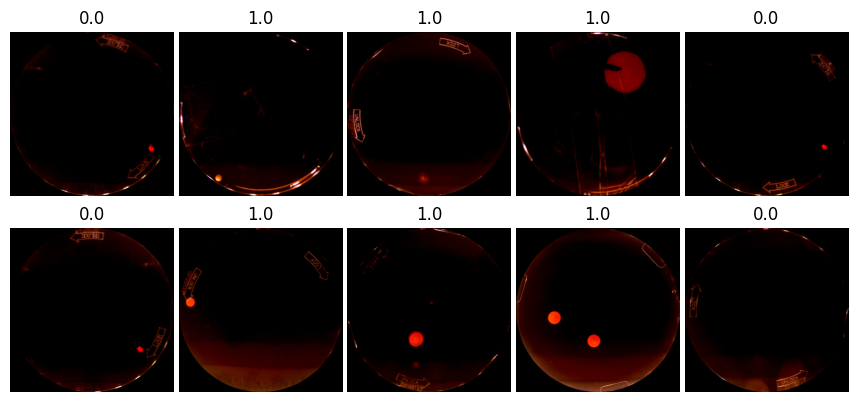

In [14]:
# Visualize first 10 images of the main dataset to make sure it makes sense
num_rows=2
num_ncols=5
fig, axs = plt.subplots(nrows=num_rows, ncols=num_ncols, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(num_rows) for j in np.arange(num_ncols)]:
    idx = 5*i+j
    image = X_shuffled[idx]
    axs[i,j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_shuffled[idx])
    axs[i,j].axis('off')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.4, wspace=0.02, hspace=0.2)
plt.show()

**Common Constants**

In [58]:
BATCH_SIZE = 32   # Batch size for training
EPOCHS = 40       # Number of epochs for training
TEST_SIZE = 0.2   # Validation/Train split ratio
RANDOM_STATE = 42 # The answer to the ultimate question of life, the universe, and everything   
ACCURACY_THRESHOLD = 0.9           # Set the desired accuracy threshold
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, 3)       # Define the input_shape
num_classes = max(y_shuffled) + 1  # Number of clases for prediction

**Common Code** - Prepare Data

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def prepare_data(X_shuffled, y_shuffled, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=random_state)

    # Convert labels to integers
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)

    # One-hot encode the labels
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    return X_train, X_val, y_train, y_val


**Common Code** - Evaluate Model

In [38]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

def evaluate_model(model, history, X_val, y_val, plot_target = False):
    # Evaluate the model
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)

    y_pred_dense = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    # Convergence time
    convergence = history.history['loss'][-1]

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    #Plot precision and recall
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
    _ = display.ax_.set_title("Precision-Recall curve")
    _ = display.ax_.set_xlim(0,1)
    _ = display.ax_.set_ylim(0,1)
    _ = display.ax_.spines['top'].set_visible(False)
    _ = display.ax_.spines['right'].set_visible(False)
    if plot_target:
      _ = display.ax_.fill_between([0.99,1], [0.3,0.3], [1,1], facecolor = 'green', alpha=.5)

    return f1, accuracy, convergence, recall

def evaluate_RF_model(model, X_val, y_val):
    y_true = np.argmax(y_val, axis=1)
    y_pred_dense = np.argmax(model.predict(X_val), axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    return f1, accuracy, recall


**Early Stopping Threshold**
Used to prevent overfitting on the models
Initial experiments showed that 90% accuracy on the validation set is the max we can expect from our models. We use this threshold to prevent models from trianing for too long.

In [19]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, threshold):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy is not None and val_accuracy >= self.threshold:
            self.model.stop_training = True
            print(f"\nStopping training: Validation accuracy reached {self.threshold:.2f}")

# Create the early stopping callback
early_stopping = EarlyStoppingAtAccuracy(ACCURACY_THRESHOLD)

## Make and train models. Evaluate them on validation data

### Model 0: Trivial Model

Model randomly assigns positive/negative labels with the probaility it encountered in the training set

In [20]:
class Trivial_Model:
    def __init__(self):
        self.prob = 0.5

    def fit(self, X_train, y_train_one_hot):
        y_train = np.argmax(y_train_one_hot, axis=1)
        self.prob = np.sum(y_train)/len(y_train)

    def predict(self, X):
        y_pred = [[1-self.prob, self.prob] for i in range(X.shape[0])]
        return np.array(y_pred)

tr_model = Trivial_Model()

y_val_trivial = to_categorical(labels, num_classes=2)
tr_model.fit(image_names, y_val_trivial)
print(f"There is {100*tr_model.prob:.1f}% chance of a positive (failing) sample in the whole dataset")

There is 8.4% chance of a positive (failing) sample in the whole dataset


### Model 1: In-house built CNN model

Model - 1 **Build CNN Model**

Convolutional model that we came up with after optimizing number fo layers, size of the kernels and number of filters

In [31]:
from keras.layers.normalization import batch_normalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (7, 7), activation='relu', input_shape=input_shape))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (9, 9), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (11, 11), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (13, 13), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(512, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers


**Model 1:  Train CNN Model**

In [32]:
start_time = time.time()

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Define the CNN model
# Make it so that we would have a pointer to convolutional layers
conv_layers = make_conv_layers(INPUT_SHAPE)
cnn_model = create_cnn_model(conv_layers, num_classes)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the early stopping callback
cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Epoch 1/40
 6/16 [==========>...................] - ETA: 0s - loss: 12.1820 - accuracy: 0.5885

16/16 [==============================] - 14s 361ms/step - loss: 9.0541 - accuracy: 0.6607 - val_loss: 866.8370 - val_accuracy: 0.5476
Epoch 2/40
16/16 [==============================] - 1s 80ms/step - loss: 3.2247 - accuracy: 0.7579 - val_loss: 716.5492 - val_accuracy: 0.5397
Epoch 3/40
16/16 [==============================] - 1s 80ms/step - loss: 1.9530 - accuracy: 0.7460 - val_loss: 399.6732 - val_accuracy: 0.5397
Epoch 4/40
16/16 [==============================] - 1s 81ms/step - loss: 2.1887 - accuracy: 0.8095 - val_loss: 198.6409 - val_accuracy: 0.5397
Epoch 5/40
16/16 [==============================] - 1s 81ms/step - loss: 1.6524 - accuracy: 0.8135 - val_loss: 143.2093 - val_accuracy: 0.5397
Epoch 6/40
16/16 [==============================] - 1s 80ms/step - loss: 0.5298 - accuracy: 0.8452 - val_loss: 75.6812 - val_accuracy: 0.5397
Epoch 7/40
16/16 [==============================] - 1s 80ms/step - loss: 0.4138 - accuracy: 0.8730 - val_loss: 14.4588 - val_accuracy: 0.5556
Epoch 8/40

5880

**Model 1: Evaluate CNN Model on validation dataset**

4/4 [==============================] - 0s 23ms/step
F1 score: 87.3%, accuracy: 87.3%, recall 86.8%
Convergence time: 0.1535 sec

Time taken: 0.3244 seconds
Total Memory: 85487.04 MB
Available Memory: 72916.79 MB
Memory usage: 10684.72 MB
CPU usage: 3.4%


''

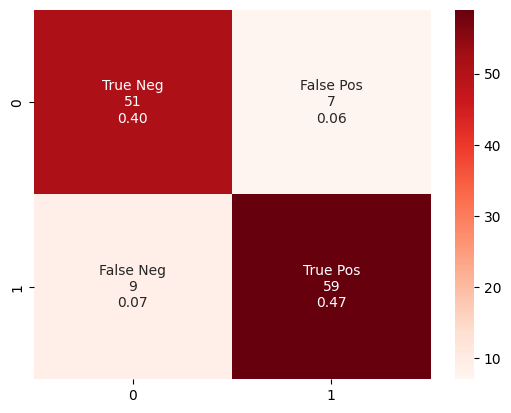

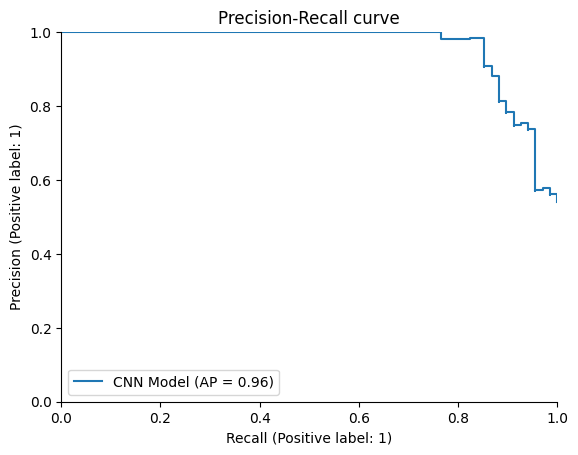

In [39]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(cnn_model, cnn_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


### Model 1.1: Random Forest with convolutional layers

Model - 1.1 **Random Forest on Conv layers of home made CNN**

In [35]:
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Make a forward pass through convolutional layers
#This will be a set of features to train RF
X_for_RF = conv_layers.predict(X_train) 

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

16/16 [==============================] - 0s 23ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

4/4 [==============================] - 0s 24ms/step
F1 score: 0.8890
Accuracy: 0.8889
Recall: 0.8824



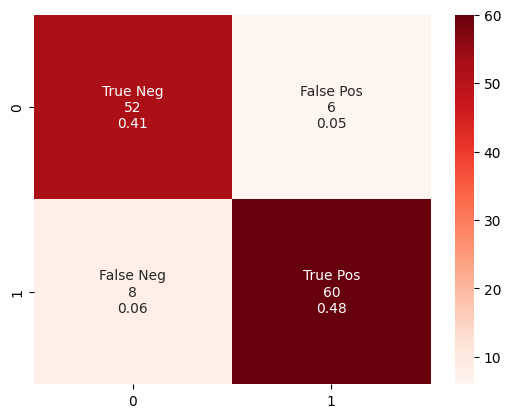

In [36]:
# Evaluate RF model
#Send test data through same feature extractor process
X_test_feature = conv_layers.predict(X_val)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_val)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"")

### Model 2: Transfer learning with Efficient Net

Model 2 - **Build and train Efficient Net**

In [40]:
start_time = time.time()

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
efficientnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Freeze the base model's layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the early stopping callback
efficientnet_history = efficientnet_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()



16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/40
16/16 [==============================] - 10s 208ms/step - loss: 0.6358 - accuracy: 0.6468 - val_loss: 0.5439 - val_accuracy: 0.6984
Epoch 2/40
16/16 [==============================] - 1s 79ms/step - loss: 0.4217 - accuracy: 0.8115 - val_loss: 0.4382 - val_accuracy: 0.8016
Epoch 3/40
16/16 [==============================] - 1s 80ms/step - loss: 0.3753 - accuracy: 0.8353 - val_loss: 0.3875 - val_accuracy: 0.8175
Epoch 4/40
16/16 [==============================] - 1s 80ms/step - loss: 0.3393 - accuracy: 0.8512 - val_loss: 0.3902 - val_accuracy: 0.8175
Epoch 5/40
16/16 [==============================] - 1s 79ms/step - loss: 0.3182 - accuracy: 0.8889 - val_loss: 0.4025 - val_accuracy: 0.8254
Epoch 6/40
16/16 [==============================] - 1s 81ms/step - loss: 0.3230 - accuracy: 0.8750 - val_loss: 0.3535 - val_accuracy: 0.8413
Epoch 7/40
16/16 [==============================] - 1s 79ms/step - loss: 0.2886 - accur

4

**Evaluate EfficientNet**

4/4 [==============================] - 0s 60ms/step
F1 score: 86.4%, accuracy: 86.5%, recall 76.5%
Convergence time: 0.1712 sec

Time taken: 0.4627 seconds
Total Memory: 85487.04 MB
Available Memory: 72765.15 MB
Memory usage: 10879.74 MB
CPU usage: 3.1%


''

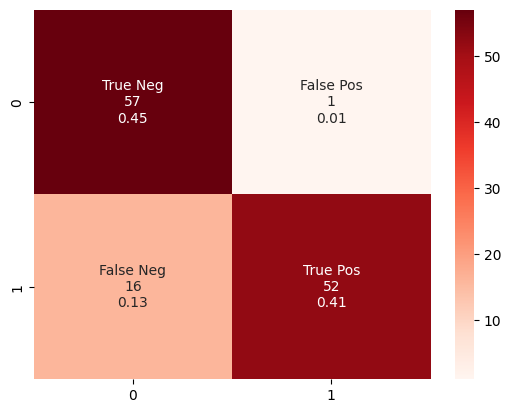

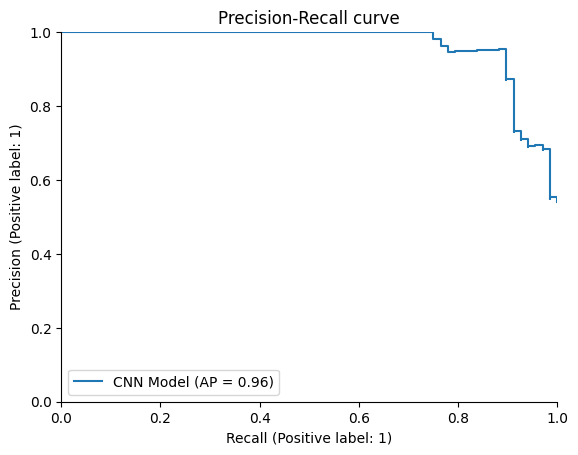

In [42]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(efficientnet_model,efficientnet_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


### Model 3.1: Transfer learning with ResNet50

Model 3 - **ResNet50 Model**

In [29]:
start_time = time.time()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the base model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
resnet50_history = resnet50_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/40
15/15 [==============================] - 8s 233ms/step - loss: 0.9539 - accuracy: 0.5055 - val_loss: 0.6183 - val_accuracy: 0.7451
Epoch 2/40
15/15 [==============================] - 1s 69ms/step - loss: 0.5879 - accuracy: 0.6954 - val_loss: 0.5367 - val_accuracy: 0.8039
Epoch 3/40
15/15 [==============================] - 1s 68ms/step - loss: 0.4819 - accuracy: 0.8057 - val_loss: 0.5296 - val_accuracy: 0.7451
Epoch 4/40
15/15 [==============================] - 1s 68ms/step - loss: 0.4423 - accuracy: 0.8234 - val_loss: 0.4637 - val_accuracy: 0.8431
Epoch 5/40
15/15 [==============================] - 1s 70ms/step - loss: 0.4084 - accuracy: 0.8477 - val_loss: 0.5109 - val_accuracy: 0.7451
Epoch 6/40
15/15 [==============================] - 1s 68ms/step - loss: 0.3877 - accuracy: 0.8521 - val_loss: 0.4337 - val_accuracy: 0.8431
Epoch 7/40
15/15 [==============================] - 1s 68ms/step - loss: 0.3862 - accura

15839

**Evaluate ResNet50 Model**

4/4 [==============================] - 0s 62ms/step
F1 score: 88.1%, accuracy: 88.1%, recall 80.9%
Convergence time: 0.1804 sec

Time taken: 0.4646 seconds
Total Memory: 85487.04 MB
Available Memory: 72767.21 MB
Memory usage: 10881.45 MB
CPU usage: 4.0%


''

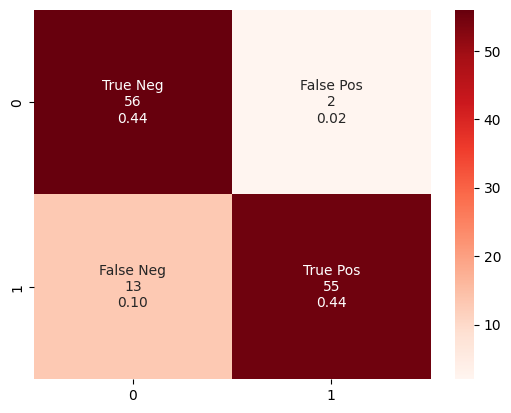

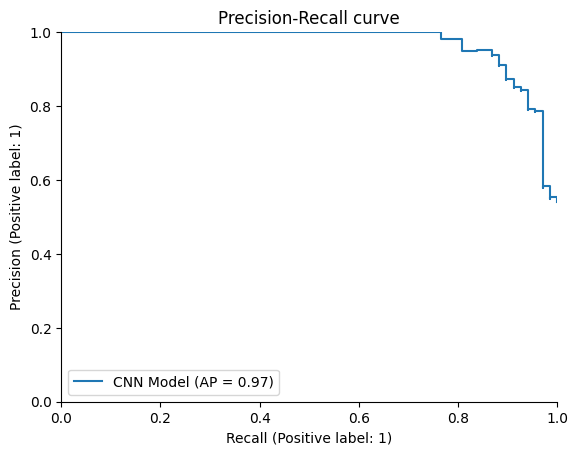

In [43]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(resnet50_model,resnet50_history, X_val, y_val)
end_time = time.time()

# Print the results

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


### Model 3.2: Transfer learning with ResNet50, alternative sequence

Model 5 - **Resnet50 Model - Sequence 2**

In [46]:
start_time = time.time()

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


resnet_model2 = Sequential()
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  pooling='avg',
                                                  weights='imagenet')
for layer in pretrained_model.layers:
  layer.trainable=False

resnet_model2.add(pretrained_model)
resnet_model2.add(Flatten())
resnet_model2.add(Dense(512, activation='relu'))
resnet_model2.add(Dense(2, activation='softmax'))

resnet_model2.summary()

resnet_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

resnet_history2 = resnet_model2.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dense_12 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/40
16/16 [==============================] - 6s 148ms/step - loss: 1.6760 - accuracy: 0.6548 - val_loss: 0.5631 - val_accuracy: 0.7381
Epoch 2/40
16/16 [======

38928

Evaluate Resnet Model Sequence 2

4/4 [==============================] - 1s 63ms/step
F1 score: 73.4%, accuracy: 74.6%, recall 52.9%
Convergence time: 0.2061 sec

Time taken: 1.3762 seconds
Total Memory: 85487.04 MB
Available Memory: 72592.59 MB
Memory usage: 11039.48 MB
CPU usage: 3.2%


''

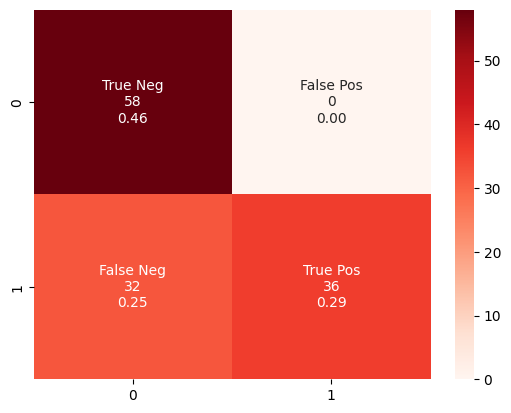

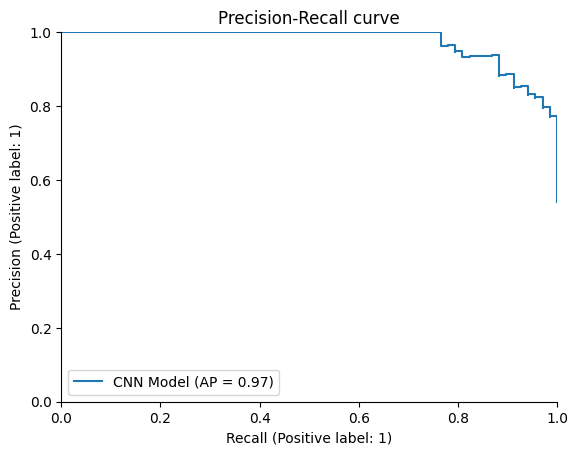

In [47]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(resnet_model2,resnet_history2, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


### Model 4: Transfer learning with VGG16

Model 4 -**VGG16 Model**

In [20]:

start_time = time.time()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Preprocess the images using the VGG16 preprocessing function
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Create the base model using VGG16, then freez it
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

flatten_layer = Flatten()
dense_layer_1 = Dense(256, activation='relu')
drop = Dropout(0.5)
prediction_layer = Dense(num_classes, activation='softmax')

# Create the final model and compile it
vgg16_model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop,
    prediction_layer
])
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TEST_SIZE, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/40
13/13 [==============================] - 18s 455ms/step - loss: 55.7215 - accuracy: 0.5856 - val_loss: 10.2870 - val_accuracy: 0.7723
Epoch 2/40
13/13 [==============================] - 2s 136ms/step - loss: 18.9679 - accuracy: 0.7593 - val_loss: 7.9146 - val_accuracy: 0.7327
Epoch 3/40
13/13 [==============================] - 2s 137ms/step - loss: 6.5257 - accuracy: 0.8561 - val_loss: 9.1847 - val_accuracy: 0.6634
Epoch 4/40
13/13 [==============================] - 2s 137ms/step - loss: 2.5802 - accuracy: 0.8859 - val_loss: 5.5037 - val_accuracy: 0.7921
Epoch 5/40
13/13 [==============================] - 2s 136ms/step - loss: 0.8255 - accuracy: 0.9231 - val_loss: 3.3828 - val_accuracy: 0.8020
Epoch 6/40
13/13 [==============================] - 2s 136ms/step - loss: 0.2918 - accuracy: 0.9504 - val_loss: 3.4872 - val_accuracy: 0.7921
Epoch 7/40
13/13 [==============================] - 2s 139ms/step - loss: 0.188

1532

4/4 [==============================] - 0s 94ms/step
F1 score: 64.5%, accuracy: 67.5%, recall 92.6%
Convergence time: 0.0992 sec

Time taken: 0.5917 seconds
Total Memory: 85487.04 MB
Available Memory: 72618.64 MB
Memory usage: 11039.48 MB
CPU usage: 5.1%


''

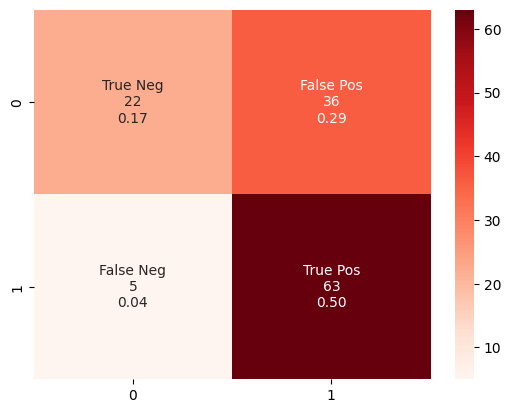

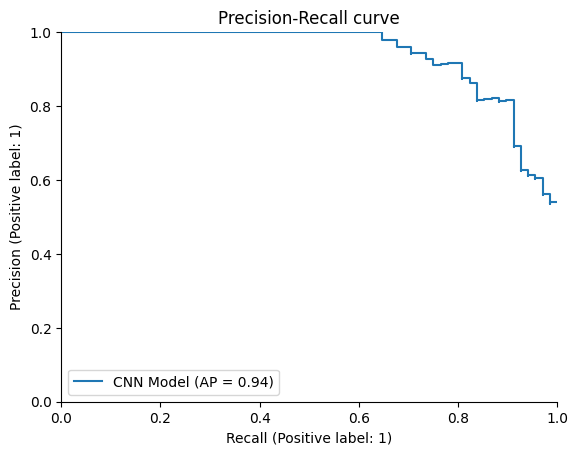

In [48]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence,recall = evaluate_model(vgg16_model,vgg16_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


### Model 5: Transfer learning with Inception model

Model 5- **Inception Model**

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

start_time = time.time()

Inception_model = InceptionV3(input_shape = INPUT_SHAPE, include_top = False, weights = 'imagenet')

for layer in Inception_model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(Inception_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(2, activation='softmax')(x)

final_inception_model = tf.keras.models.Model(Inception_model.input, x)

final_inception_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['acc'])


# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inception_history = final_inception_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/40
16/16 [==============================] - 14s 449ms/step - loss: 192.6130 - acc: 0.6726 - val_loss: 152.0365 - val_acc: 0.6508
Epoch 2/40
16/16 [==============================] - 1s 65ms/step - loss: 138.4992 - acc: 0.7321 - val_loss: 84.4452 - val_acc: 0.7937
Epoch 3/40
16/16 [==============================] - 1s 64ms/step - loss: 33.5671 - acc: 0.8433 - val_loss: 54.6719 - val_acc: 0.8413
Epoch 4/40
16/16 [==============================] - 1s 65ms/step - loss: 18.6138 - acc: 0.8929 - val_loss: 40.6626 - val_acc: 0.7619
Epoch 5/40
16/16 [==============================] - 1s 65ms/step - loss: 6.5990 - acc: 0.9167 - val_loss: 43.1267 - val_acc: 0.7937
Epoch 6/40
16/16 [==============================] - 1s 65ms/step - loss: 8.8836 - acc: 0.9206 - val_loss: 38.2394 - val_acc: 0.7778
Epoch 7/40
16/16 [==============================] - 1s 65ms/step - loss: 6.4740 - acc: 0.9147 - val_loss: 24.0190 - val_acc: 0.8175
Ep

9466

Evaluate Inception Model

4/4 [==============================] - 0s 51ms/step
F1 score: 80.1%, accuracy: 80.2%, recall 85.3%
Convergence time: 2.0801 sec

Time taken: 0.4214 seconds
Total Memory: 85487.04 MB
Available Memory: 72565.62 MB
Memory usage: 11039.46 MB
CPU usage: 5.6%


''

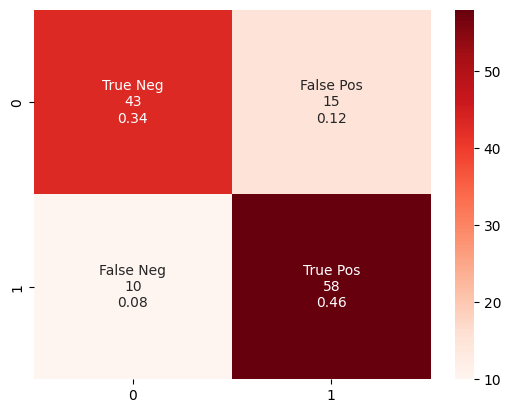

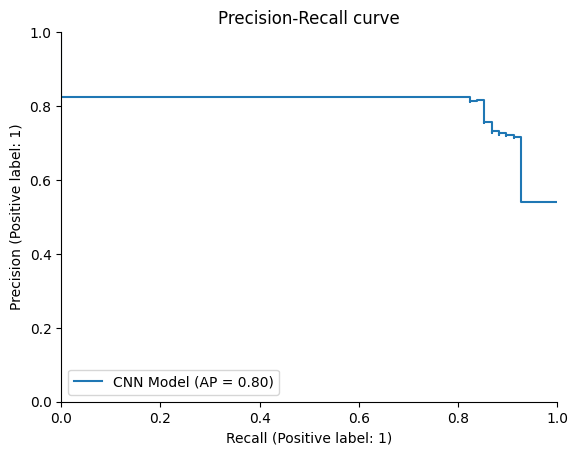

In [49]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence, recall = evaluate_model(final_inception_model,inception_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

print_time_memory_detail(start_time, end_time)


## Compare models on benchmark dataset

**Load benchmark dataset**

This is a 14% subsection of the original dataset that was separated early on  and was not used for training. This dataset is represenative of the original dataset - highly biased toward the negative cases.

In [24]:
#Benchmark set, shard on GDrive with everybody in the UC Berkeley organization
file_link_benchmark = "https://drive.google.com/drive/folders/1eUee9UuJLHpH-pghmdvZ1lZ__9ry3hGb?usp=share_link"

# Get the folder ID for benchmark data
folder_id_1 = file_link_benchmark.split("/")[-1]
folder_id_bnmrk = folder_id_1 .split("?")[0] 
print('benchmark dataset folder id', folder_id_bnmrk )

# Query GDrive and get a dict of files and ID's in the benchhmark dataset
query = "mimeType='{}' and parents='{}'".format(mime_type, folder_id_bnmrk)
page_token = ""
filelist_bnmrk = {}
while True:
    response = service.files().list(q=query,
                                supportsAllDrives='true',
                                includeItemsFromAllDrives='true',
                                pageSize=1000,
                                fields='nextPageToken, files(id, name)',
                                pageToken=page_token).execute()

    page_token = response.get('nextPageToken', None)
    filelist_bnmrk.setdefault("files",[]).extend(response.get('files'))

    if (not page_token):
        break

items_bnmrk = filelist_bnmrk['files']
print("Number of Files in benchmark dataset: ",len(items_bnmrk))


# loop through all files and generate labels from the names, save names in a list
# also put names of the files in the list as well
# Last digit in the file name - number of colonies that expert found
# If there are any colonies we call the case positive, the sample is not sterile

names_bnmrk = []
id_dict_bnmrk = {}
labels_bnmrk = []
for item in items_bnmrk:
    id_dict_bnmrk[item["name"]] = item["id"]
    names_bnmrk.append(item["name"])
    num_colonies = int(names_bnmrk[-1].split('-')[2].strip().split('.')[0])
    if num_colonies == 0:
      labels_bnmrk.append(0)
    else:
      labels_bnmrk.append(1)

y_bnmrk = np.array(labels_bnmrk)

#Load the actual files, resize them to the same size as training dataset
start_time = time.time()

print(f"Loading benchmark images" )
images_bnmrk = []
for i, file_name in enumerate(names_bnmrk):
    # Get the file from Google Drive
    file_id = id_dict_bnmrk[file_name]
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile(file_name)
    img = cv2.imread(file_name)
    img = cv2.resize(img, (SIZE,SIZE))
    images_bnmrk.append(img)

    # Print the pixel size of the image
    # print(f"file #{i}: {file_name} ID: {file_id} Pixel size: {img.shape}" )
    print(f"{i}", end = ' ')
    if i%25 == 0:
      print("")

end_time = time.time()
print_time_memory_detail(start_time, end_time)


print("\nforcing gc..")
gc.collect()

# Normalize benchmark dataset
X_bnmrk = np.array(images_bnmrk)



benchmark dataset folder id 1eUee9UuJLHpH-pghmdvZ1lZ__9ry3hGb
Number of Files in benchmark dataset:  609
Loading benchmark images
0 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 
126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 
151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 
176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 
226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 24

In [26]:
# Common data transformation
from tensorflow.keras.utils import to_categorical
y_bnmrk_onehot = to_categorical(labels_bnmrk, num_classes=2)

#### **Model 0: Evaluate trivial model on benchmark dataset**

Accuracy: 91.6


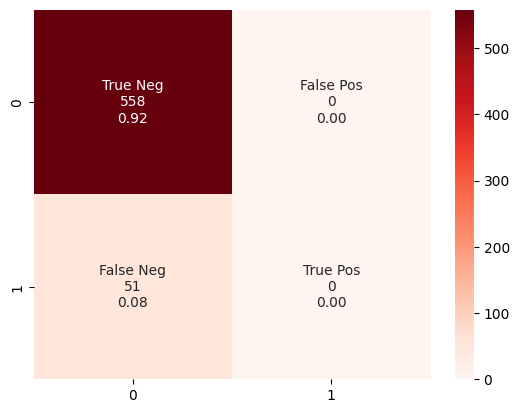

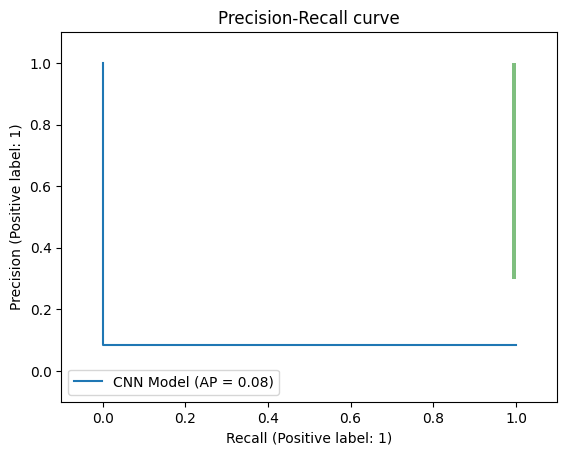

In [ ]:
# Make predictions
y_true = np.argmax(y_bnmrk_onehot, axis=1)
y_pred = tr_model.predict(X_bnmrk)
y_pred_dense = np.argmax(y_pred, axis=1)

f1 = f1_score(y_true, y_pred_dense, average='weighted')
accuracy = accuracy_score(y_true, y_pred_dense)
recall = recall_score(y_true, y_pred_dense)

#Plot confusion matrics
cm = confusion_matrix(y_true, y_pred_dense)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f'{value}' for value in cm.flatten()]
group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

#Plot precision and recall
display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
_ = display.ax_.set_title("Precision-Recall curve")
_ = display.ax_.set_xlim(-0.1,1.1)
_ = display.ax_.set_ylim(-0.1,1.1)
_ = display.ax_.fill_between([0.99,1], [0.3,0.3], [1,1], facecolor = 'green', alpha=.5)

accuracy = np.sum([1 for tru, pred in zip (y_true, y_pred_dense) if tru == pred])/len(y_true)

print(f"Accuracy: {100*accuracy:.1f}%, recall {100*recall:.f}%")

#### **Model 1: Evaluate an in-house made CNN and RF on benchmark dataset**

20/20 [==============================] - 0s 22ms/step
F1 score: 87.8%, accuracy: 85.2%, recall 82.4%
Convergence time: 0.1535 sec



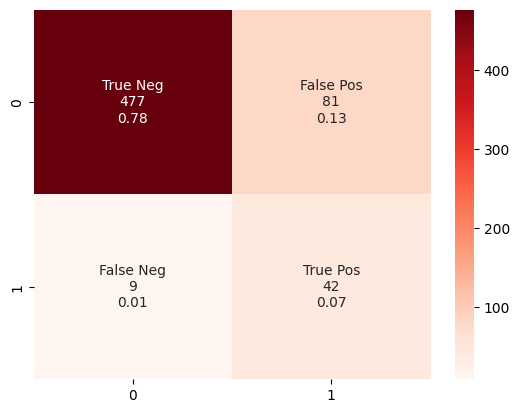

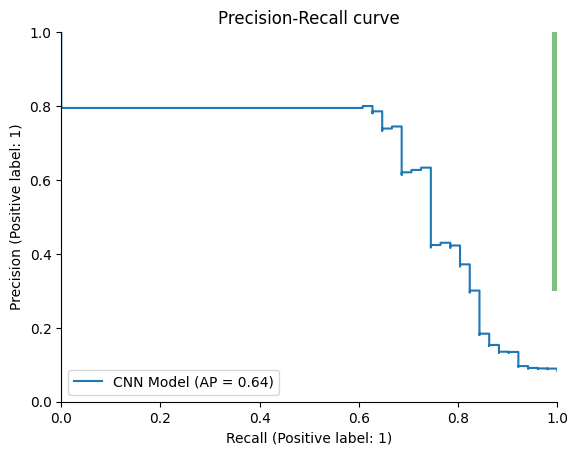

In [50]:
f1, accuracy, convergence, recall = evaluate_model(cnn_model, cnn_history, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"Convergence time: {convergence:.4f} sec")
print(f"")

20/20 [==============================] - 0s 22ms/step
F1 score: 87.0%, accuracy: 84.4%, recall 74.5%



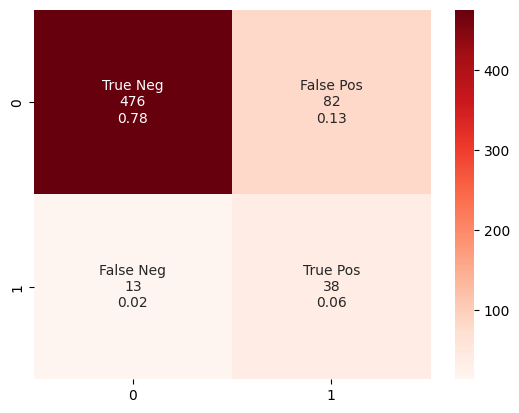

In [51]:
# Evaluate RF model
#Send test data through same feature extractor process

X_test_feature = conv_layers.predict(X_bnmrk)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")

#### **Model 2: Evaluate EffNet model on the benchmark data**

20/20 [==============================] - 1s 60ms/step
F1 score: 95.8%, accuracy: 95.7%, recall 76.5%



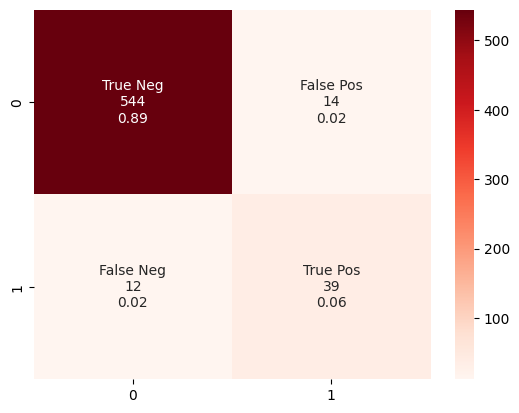

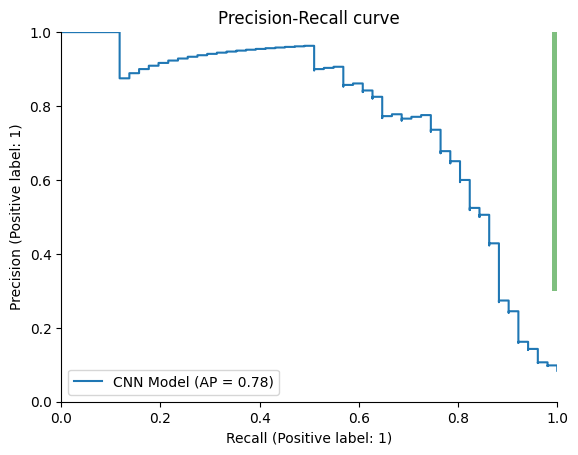

In [52]:
f1, accuracy, convergence, recall = evaluate_model(efficientnet_model,efficientnet_history, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")

#### **Model 3: Evaluate Resnet50 on benchmark data**

20/20 [==============================] - 1s 72ms/step
F1 score: 92.4%, accuracy: 91.6%, recall 76.5%



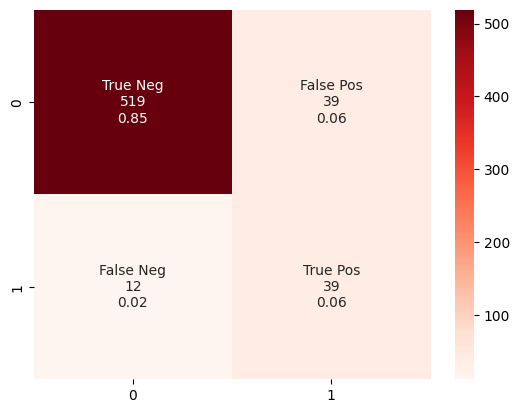

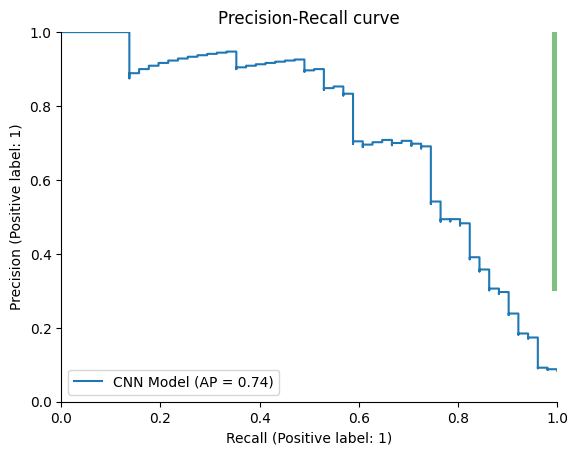

In [53]:
f1, accuracy, convergence, recall = evaluate_model(resnet50_model,resnet50_history, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")

#### **Model 3: Evaluate ResNet50 Model2 on Benchmark Dataset**

20/20 [==============================] - 1s 58ms/step
F1 score: 94.9%, accuracy: 95.6%, recall 49.0%



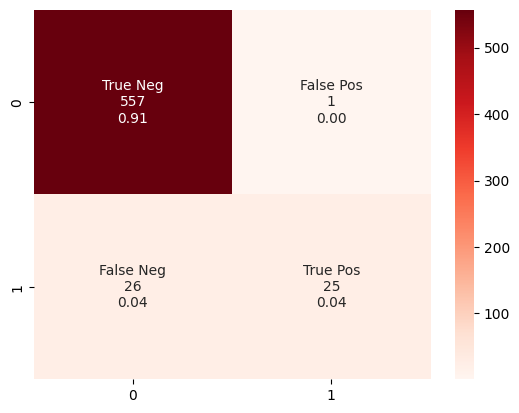

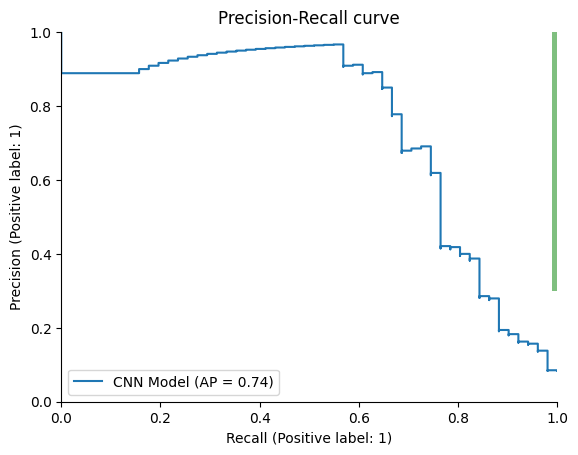

In [55]:
f1, accuracy, convergence, recall = evaluate_model(resnet_model2,resnet_history2, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")

#### **Model 4: Evaluate vgg16 model on the benchmark data**

20/20 [==============================] - 2s 87ms/step
F1 score: 51.4%, accuracy: 42.2%, recall 98.0%



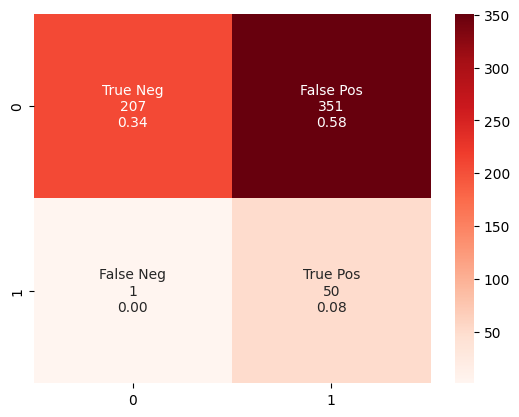

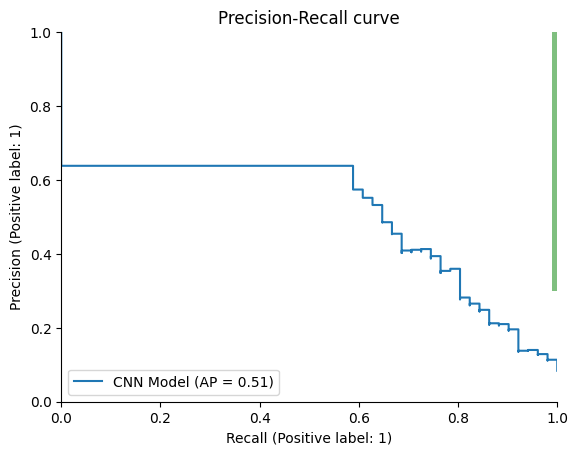

In [56]:
f1, accuracy, convergence, recall = evaluate_model(vgg16_model,vgg16_history, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")

#### **Model 5: Evaluate Inception Model on Benchmark Dataset**

20/20 [==============================] - 1s 45ms/step
F1 score: 78.9%, accuracy: 72.9%, recall 84.3%



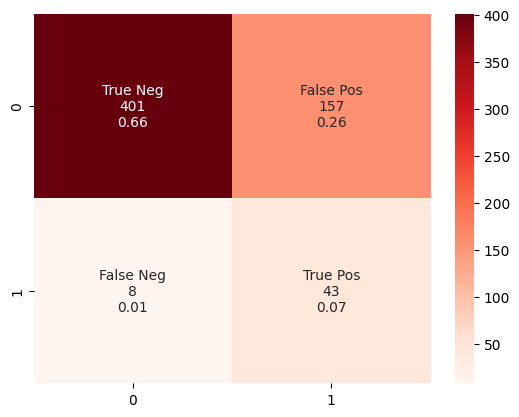

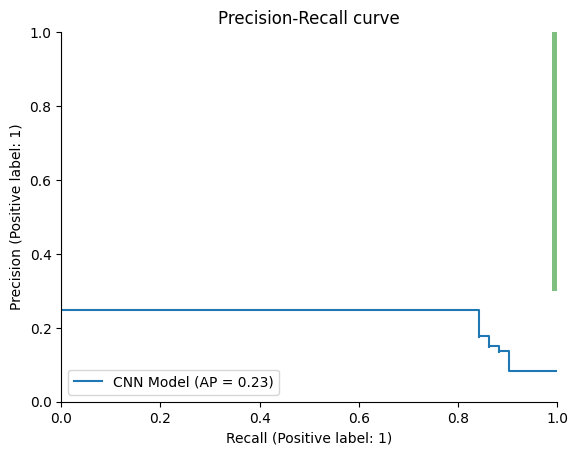

In [57]:
f1, accuracy, convergence, recall = evaluate_model(final_inception_model,inception_history, X_bnmrk, y_bnmrk_onehot, True)

# Print the results
print(f"F1 score: {100*f1:.1f}%, accuracy: {100*accuracy:.1f}%, recall {100*recall:.1f}%")
print(f"")